## Laptop Price Predictor: Machine Learning for Production Environments

_completed June 30, 2025_

_author:_
- Joe Tolsma (tolsmajdx@gmail.com)

_datasets:_
- public data sourced from https://www.kaggle.com/datasets/arnabchaki/laptop-price-prediction
- accessed June 9, 2025
- note: price currency is Indian Rupees (INR)

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
import re
import math
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import joblib
from pathlib import Path

In [64]:
MODEL_PATH = Path("laptop_predictor_files/model")

### Section 1: Basic EDA

In [65]:
# the data is pre-split into training and test sets
# let's combine them here; they may be re-split later but the train-test distinction means nothing now
import1 = pd.read_csv("training_data/laptops_train.csv",thousands = ",")
import2 = pd.read_csv("training_data/laptops_test.csv",thousands = ",")

price_df = pd.concat([import1,import2],axis = 0).reset_index(drop = True)

#### Checking For Missing Values

In [66]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Manufacturer              1302 non-null   object 
 1   Model Name                1302 non-null   object 
 2   Category                  1302 non-null   object 
 3   Screen Size               1302 non-null   object 
 4   Screen                    1302 non-null   object 
 5   CPU                       1302 non-null   object 
 6   RAM                       1302 non-null   object 
 7    Storage                  1302 non-null   object 
 8   GPU                       1302 non-null   object 
 9   Operating System          1302 non-null   object 
 10  Operating System Version  1132 non-null   object 
 11  Weight                    1302 non-null   object 
 12  Price                     1302 non-null   float64
dtypes: float64(1), object(12)
memory usage: 132.4+ KB


In [67]:
price_df.sample(2,random_state = 42)

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
478,Dell,Inspiron 3576,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,1TB HDD,AMD Radeon 520,Windows,10,2.2kg,6002100.00
724,MSI,GL72M 7REX,Gaming,"17.3""",Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows,10,2.7kg,11990684.16


#### Found Missing Values

`Operating System Version` has null values -- need to impute

In [68]:
# investigating the best way to fill missing values in "Operating System Version"
display(pd.DataFrame(price_df["Operating System Version"].value_counts(dropna = False).sort_index()))
display(pd.DataFrame(price_df[["Operating System","Operating System Version"]].value_counts(dropna = False)).sort_index())

,count
Operating System Version,
10,1071
10 S,8
7,45
X,8
NaN,170


count
Operating System Operating System Version       
Android          NaN                           2
Chrome OS        NaN                          27
Linux            NaN                          62
Mac OS           X                             8
No OS            NaN                          66
Windows          10                         1071
                 10 S                          8
                 7                            45
macOS            NaN                          13

`Operating System Version` has three issues:
1) 'Mac OS' and 'macOS' coexist in the dataset and need to be unified
2) Several operating systems are unversioned
3) Several machines have no operating system installed 

In [69]:
# unifying 'Mac OS' and 'macOS'
price_df["Operating System"] = price_df["Operating System"].replace(to_replace = "macOS",value = "Mac OS")

# filling MacOS missing OS version with the most commom (known) MacOS version in the dataset
macos_df = price_df.groupby(["Operating System","Operating System Version"])["Operating System Version"].count().rename("Operating System Count").reset_index()
macos_df = macos_df[macos_df["Operating System"] == "Mac OS"]
macos_missing_version_fill = macos_df.iloc[macos_df["Operating System Count"].idxmax()]["Operating System Version"]
price_df.loc[price_df["Operating System"] == "Mac OS",["Operating System Version"]] = macos_missing_version_fill

# dealing with unversioned or uninstalled operating systems
price_df.loc[price_df["Operating System"] == "No OS",["Operating System Version"]] = "No OS"
price_df["Operating System Version"] = price_df["Operating System Version"].fillna("Unversioned")

### Section 2: Feature Engineering

#### Feature Engineering Strategies

**Simple Categorical Variables:**
* `Manufacturer, Model Name, Category, Operating System, Operating System Version`:

    - Encode the most common values with integers
    
    - Group rare values into an "other" category and encode with a single integer
    
    - If the most common values are < 80-90% of total values, do not use as a feature
    
**Complex Categorical Variables**
* `CPU, GPU`:

    - Break into columns containing brand, product, clock speed, and other simple components

    - For simple components that are categorical, use the feature encoding approach described for "simple categorical variables" above

    - For numerical components, convert to numerical datatypes

**Numerical Data + Metadata**
* `Storage`

    - Calculate total GB capacity

    - Segment total GB by format (SSD GB, HDD GB, etc.)

* `Screen`

    - Compute resolution (pixels/in) in combination with `Screen Size`

    - Use one-hot encoding to identify common marketing terms ("Retina")

**Simple Numerical**
* `RAM, Weight`

- Remove units ("GB","kg") and convert to numerical datatypes

#### Create Functions to Enable Feature Engineering

In [70]:
# In a categorical column (e.g. Manufacturer), compute the top N categories by frequency
# Replace all categories outside of top N with "other"
# Also return proportion of total values comprised by top N -> if < 80-90%, don't encode or use as a feature

def TopNCategories(series, N=10, replace_string="Other"):
    top_N_idx = series.value_counts().nlargest(N).index
    top_N_df = series.where(series.isin(top_N_idx), replace_string)
    ratio = top_N_df[top_N_df != replace_string].shape[0] / top_N_df.shape[0]
    return top_N_df,ratio

In [71]:
# Convert text-based categorical features to integer encodings
# Use together with TopNCategories -> find top N categories and give them distinct encodings
# ...then encode all others with a single integer value

def NumericalEncode(series:pd.Series,replace_string:str) -> pd.Series:
    unique_item_map = {code:idx for idx,code in enumerate(series.unique())}
    feature_encoded = series.map(unique_item_map)
    if replace_string in series.unique():
        feature_encoded.fillna(replace_string)
    
    return feature_encoded, unique_item_map

#### Feature Engineering: Manufacturer

In [72]:
# Compute top N manufacturers and determine if encoding is appropriate

N_manufs = 8
replace_string_manuf = "Other"

top_manufs, top_manufs_ratio = TopNCategories(price_df["Manufacturer"],N = N_manufs,replace_string=replace_string_manuf)

print(f"The ratio of top {N_manufs} most common models to all models is {round(top_manufs_ratio*100,1)}%")

The ratio of top 8 most common models to all models is 96.1%


In [73]:
# Since numerical encoding makese sense here, use the dedicated function to encode
manuf_encoded, manuf_code_map = NumericalEncode(top_manufs,replace_string = replace_string_manuf)

# Display some sample data
pd.concat([price_df["Manufacturer"],manuf_encoded],axis = 1).sample(5,random_state=42)

,Manufacturer,Manufacturer
478,Dell,4
724,MSI,7
312,MSI,7
851,Asus,3
1275,Dell,4


#### Feature Engineering: Model

In [74]:
# Compute top N manufacturers and determine if encoding is appropriate

N_models = 20
replace_string_model = "Other"
top_models, top_models_ratio = TopNCategories(price_df["Model Name"],N = N_models,replace_string=replace_string_model)

print(f"The ratio of top {N_models} most common models to all models is {round(top_models_ratio*100,1)}%")

The ratio of top 20 most common models to all models is 23.1%


In [75]:
# Since numerical encoding is not suitable, I made a frequency-based feature
# Later, I realized that a frequency-based feature makes no sense for serving individual predictions, so it was dropped

model_freq = price_df["Model Name"].value_counts().rename("Model Freq").to_frame().reset_index()
model_freq = pd.merge(price_df["Model Name"],model_freq,how = "left",on = "Model Name")
model_freq.sample(5,random_state=42)

,Model Name,Model Freq
478,Inspiron 3576,6
724,GL72M 7REX,2
312,GE63VR 7RF,1
851,Rog GL502VM-DS74,1
1275,Inspiron 3567,29


In [76]:
model_freq.drop("Model Name",axis = 1,inplace = True)

#### Feature Engineering: Category

In [77]:
# Compute top N categories and determine if encoding is appropriate
N_cats = 10
replace_string_cat = "Other"
top_cats,top_cat_ratio = TopNCategories(price_df["Category"],N = N_cats, replace_string=replace_string_cat)

print(f"The ratio of top {N_cats} most common laptop categories to all categories is {round(top_cat_ratio*100,1)}%")

The ratio of top 10 most common laptop categories to all categories is 100.0%


In [78]:
# Since numerical encoding makese sense here, use the dedicated function to encode
category_encoded, category_code_map = NumericalEncode(top_cats,replace_string=replace_string_cat)

# Display some sample data
pd.concat([price_df["Category"],category_encoded],axis = 1).sample(5,random_state=42)

,Category,Category
478,Notebook,1
724,Gaming,3
312,Gaming,3
851,Gaming,3
1275,Notebook,1


#### Feature Engineering: Screen

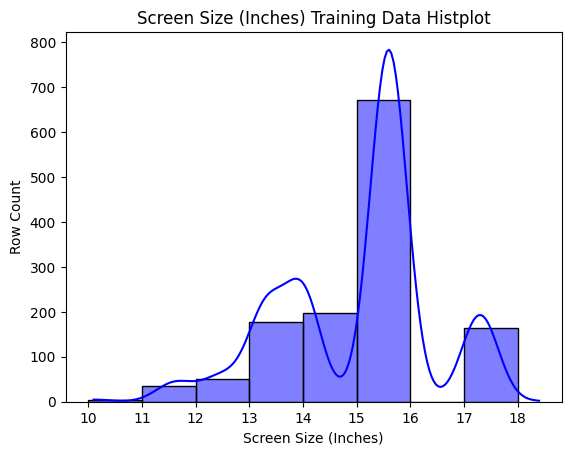

In [79]:
# Convert screen size (stored as strings with units included) to numerical type
price_df["Screen Size"] = price_df["Screen Size"].str.strip('"').astype("float32")
screen_in = price_df["Screen Size"]

# Plot the distribution to look for outliers or other unusual patterns
plot_bins = np.arange(
    start = int(screen_in.min()), 
    stop = int(screen_in.max())+1, 
    step = 1
)

ax = sns.histplot(data = screen_in,kde=True,bins = plot_bins,color = "blue")
ax.set_xticks(plot_bins)
ax.set_xlabel("Screen Size (Inches)")
ax.set_ylabel("Row Count")
ax.set_title("Screen Size (Inches) Training Data Histplot");

In [80]:
# Use a dedicated function to convert "Screen" data to one-hot columns of marketing terms, as well as total pixels

def FeaturizeScreen(screen_spec:str) -> Dict:

    screen_keywords = r'\b(IPS|4K|Touchscreen|Retina)\b' # regex containing common marketing terms

    # regex search function
    found_keywords = re.findall(screen_keywords,screen_spec,re.IGNORECASE)
    found_keywords = [x.upper() for x in found_keywords]  

    # store presence or absence of each marketing term as a local variable
    has_ips = int("IPS" in found_keywords)
    has_4k = int("4K" in found_keywords)
    has_touchscreen = int("TOUCHSCREEN" in found_keywords)
    has_retina = int("RETINA" in found_keywords)

    pixel_dim_pattern = r'(?P<width>\d{3,4})\s*[xX×]\s*(?P<height>\d{3,4})' # regex searching for pixel dimensions

    # store pixel dimensions as the quantity of total diagonal pixels
    match = re.search(pixel_dim_pattern,screen_spec)
    if match:
        width = int(match.group("width"))
        height = int(match.group("height"))
        # pixel_count = width*height # replaced with size-normalized resolution
        diag_pixels = math.sqrt(width**2 + height**2)
    else:
        diag_pixels = None

    # return one-hot encoded columns for marketing terms and diagonal resolution
    return {"IPS":has_ips,"4K":has_4k,"Touchscreen":has_touchscreen,"Retina":has_retina,"Diag Resolution":diag_pixels}


In [81]:
# combine the output of the "FeaturizeScreen" function with the screen size column
screen_features = pd.concat([
    pd.DataFrame(price_df["Screen"].apply(FeaturizeScreen).tolist()),
    screen_in
],axis = 1
)

# Compute a "pixels per inch" value for each laptop using diagonal resolution and total screen size
screen_features["Screen Resolution"] = screen_features["Diag Resolution"] / screen_features["Screen Size"]
screen_features = screen_features.drop(["Diag Resolution","Screen Size"],axis = 1)

In [82]:
# Display some sample data
screen_features.sample(5,random_state=6)

,IPS,4K,Touchscreen,Retina,Screen Resolution
724,0,0,0,0,127.335680
14,1,0,0,1,226.415547
165,1,0,0,0,141.211995
823,0,0,0,0,141.211995
459,0,0,0,0,106.113067


#### Feature Engineering: CPU

In [83]:
# Use a dedicated function to break the CPU data into brand, product, clock speed, and number of cores

def FeaturizeCPU(cpu_string:str) -> Dict:

    # regex search for CPU brand, product, clock speed
    brand_clock_pattern = r'(?P<CPUBrand>Intel|AMD|Apple|Samsung)\s+(?P<CPUProduct>.*?)(?P<CPUGhz>\d+\.?\d*)\s*GHz'

    # regex pattern looking for core count using traditional Greek numerical prefixes
    core_pattern = r'\b(?P<CoreLabel>Dual|Quad|Hexa|Octa|Deca|Dodeca|Hexadeca|\d{1,2})\s+Core\b'

    brand_clock_match = re.search(brand_clock_pattern,cpu_string,re.IGNORECASE)

    if brand_clock_match:

        # store parsed text data as a dictionary
        cpu_data = brand_clock_match.groupdict()

        # convert clock speed to a number in GHz (assumes all processors are GHz)
        cpu_data['CPUGhz'] = float(cpu_data["CPUGhz"]) if cpu_data["CPUGhz"] else None

        # separate product string from other data
        core_match = re.search(core_pattern,cpu_data["CPUProduct"],re.IGNORECASE)

        # if CPU data contains a "number of cores" expression, map that expression to an integer
        if core_match:
            core_text = core_match.group("CoreLabel")
            core_map = { # overly complete to search for all possibilities, even though only 'Dual' and 'Quad' are likely
                "Dual":2,
                "Quad":4,
                "Hexa":6,
                "Octa":8,
                "Deca":10,
                "Dodeca":12,
                "Hexadeca":16
            }
        
            cpu_data["CPU Core Count"] = core_map.get(core_text.title(),None) if core_text else None

            return cpu_data
        
        # Note: most CPUs in the training dataset do not specify core counts; in these situations, leave as NaN 
        else:
            cpu_data["CPU Core Count"] = None
            return cpu_data
        
    else: 
        return {"CPUBrand":None,"CPUProduct":None,"CPUGhz":None,"CPU Core Count":None}

In [84]:
# execute the function to break CPU data into component parts
cpu_features_raw = pd.DataFrame(price_df["CPU"].apply(FeaturizeCPU).tolist())

# clean up the results
cpu_features_raw = cpu_features_raw.rename({"CPUBrand":"CPU Brand","CPUProduct":"CPU Product","CPUGhz":"CPU Ghz"},axis = 1)
cpu_features_raw["CPU Product"] = cpu_features_raw["CPU Product"].str.strip(" ")

In [85]:
# Compute top N CPU product types and determine if encoding is appropriate
N_cpu = 20
replace_string_cpu_prod = "Other"
top_cpus, top_cpu_ratio = TopNCategories(cpu_features_raw["CPU Product"],N = N_cpu,replace_string=replace_string_cpu_prod)

print(f"Top {N_cpu} CPU products constitute {round(top_cpu_ratio*100,1)}% of all possible CPU product types")

Top 20 CPU products constitute 83.6% of all possible CPU product types


In [86]:
# Compute top N CPU brands and determine if encoding is appropriate
N_cpu_brand = 8
replace_string_cpu_brand = "Other"
top_cpu_brands, top_cpu_brand_ratio = TopNCategories(cpu_features_raw["CPU Brand"],N = N_cpu,replace_string = replace_string_cpu_brand)

print(f"Top {N_cpu_brand} CPU brands constitute {round(top_cpu_brand_ratio)*100}% of all possible CPU brands")

Top 8 CPU brands constitute 100% of all possible CPU brands


In [87]:
# Since encoding makes sense for both CPU product and CPU brand, encode top N for both
cpu_prod_encoded,cpu_prod_code_map = NumericalEncode(top_cpus,replace_string=replace_string_cpu_prod)
cpu_brand_encoded,cpu_brand_code_map = NumericalEncode(top_cpu_brands,replace_string = replace_string_cpu_brand)

In [88]:
# Show some sample data
display(pd.concat([top_cpus,cpu_prod_encoded],axis = 1).sample(5,random_state=42))
display(pd.concat([cpu_features_raw["CPU Brand"],cpu_brand_encoded],axis = 1).sample(5,random_state = 1))

,CPU Product,CPU Product
478,Core i5 8250U,5
724,Core i7 7700HQ,11
312,Core i7 7700HQ,11
851,Core i7 7700HQ,11
1275,Core i3 7100U,8


,CPU Brand,CPU Brand
1232,Intel,0
1030,AMD,1
163,Intel,0
1012,Intel,0
711,Intel,0


In [89]:
# Bring together all CPU features (brand code, product code, clock speed, core count) into a single dataframe variable
cpu_features = pd.concat([
    cpu_brand_encoded, # cpu brand
    cpu_prod_encoded, # cpu product name
    cpu_features_raw["CPU Ghz"], # cpu clock speed
    cpu_features_raw["CPU Core Count"] # cpu core count
],axis = 1)

# display some sample data
cpu_features.sample(5,random_state = 2)

,CPU Brand,CPU Product,CPU Ghz,CPU Core Count
248,0,5,1.6,NaN
555,0,10,1.1,2.0
1250,1,2,2.5,NaN
547,0,14,2.3,NaN
885,0,1,2.5,NaN


#### Feature Engineering: GPU

In [90]:
# since GPU data contains brand and product only, simple "split" operation is sufficient to parse
gpu_features_raw = pd.DataFrame(price_df["GPU"].str.split(" ",n=1).to_list(),columns = ["GPU Brand","GPU Product"])

In [91]:
# Compute top N GPU product types and determine if encoding is appropriate

N_gpu = 22
replace_string_gpu_prod = "Other"
top_gpus, top_gpu_ratio = TopNCategories(gpu_features_raw["GPU Product"],N = N_gpu,replace_string=replace_string_gpu_prod)

print(f"Top {N_gpu} GPU products constitute {round(top_gpu_ratio*100,1)}% of all possible CPU product types")

Top 22 GPU products constitute 80.7% of all possible CPU product types


In [92]:
# Compute top N GPU brands and determine if encoding is appropriate
N_gpu_brand = 8
replace_string_gpu_brand = "Other"
top_gpu_brands, top_gpu_brand_ratio = TopNCategories(gpu_features_raw["GPU Brand"],N = N_gpu,replace_string = replace_string_gpu_brand)

print(f"Top {N_gpu_brand} constitute {round(top_gpu_brand_ratio)*100}% of all possible GPU brands")

Top 8 constitute 100% of all possible GPU brands


In [93]:
# Since encoding makes sense for both GPU product and GPU brand, encode top N for both
gpu_prod_encoded,gpu_prod_code_map = NumericalEncode(top_gpus,replace_string = replace_string_gpu_prod)
gpu_brand_encoded,gpu_brand_code_map = NumericalEncode(top_gpu_brands, replace_string = replace_string_gpu_brand)

In [94]:
# Show some sample data
display(pd.concat([gpu_features_raw["GPU Product"],gpu_prod_encoded],axis = 1).sample(5,random_state = 42))
display(pd.concat([gpu_features_raw["GPU Brand"],gpu_brand_encoded],axis = 1).sample(5,random_state=1))

,GPU Product,GPU Product
478,Radeon 520,16
724,GeForce GTX 1050 Ti,18
312,GeForce GTX 1070,17
851,GeForce GTX 1060,14
1275,HD Graphics 620,1


,GPU Brand,GPU Brand
1232,Nvidia,2
1030,AMD,1
163,Nvidia,2
1012,Intel,0
711,Nvidia,2


In [95]:
# combine all GPU features into a single dataframe variable

gpu_features = pd.concat([gpu_brand_encoded,gpu_prod_encoded],axis = 1)
gpu_features.sample(5,random_state = 42)

,GPU Brand,GPU Product
478,1,16
724,2,18
312,2,17
851,2,14
1275,0,1


#### Feature Engineering: RAM

In [96]:
# Convert RAM to integer by removing units "GB"

# Note: hard coding units as "GB" is appropriate here because 1) the era of MB-level RAM is over and 2) TB RAM is a long way off

ram_gb = price_df["RAM"].str.replace("GB","",regex=False).str.strip().astype("int")

#### Feature Engineeering: Storage

In [97]:
# Use a dedicated function to parse storage data into primary and secondary storage (separated by "+")
# ...then identify format and total GB for each storage drive

def FeaturizeStorage(storage_spec:str) -> Dict:

    parts = storage_spec.split("+") # split storage spec into primary and secondary (secondary may be null)
    disk_spec_list = []

    # loop over primary and secondary drive data
    for part in parts:
        part = part.strip()
        pattern_size_unit = r'(?P<size>\d+\.?\d*)\s*(?P<unit>GB|TB)' # identify quantity and units of storage
        pattern_format = r'(HDD|SSD|Flash Storage|Hybrid)' # identify drive format

        size_unit_match = re.search(pattern_size_unit,part,re.IGNORECASE)

        # convert all units to GB
        if size_unit_match:
            disk_spec = size_unit_match.groupdict()
            storage_unit_dict = {"GB":1,"TB":1000} 
            multiplier = storage_unit_dict.get(disk_spec["unit"].upper(),1)
            size_gb = float(disk_spec["size"])*multiplier
        
        else:
            size_gb = 0

        # identify a format segment for all quantities of storage
        format_match = re.search(pattern_format,part,re.IGNORECASE)
        
        # if the format is not seen in the training data (all formats in training are accounted for in this function),
        # ... assign an "Other" format
        if format_match:
            format = format_match.group(1).upper()
        else:
            format = "OTHER"

        disk_spec_list.append({"size":size_gb,"format":format})

    storage_parsed = {}

    # parse the total quantity of GB into each format type, as well as total GB
    total = sum(disk["size"] for disk in disk_spec_list)
    ssd = sum(disk["size"] for disk in disk_spec_list if disk["format"] == "SSD")
    hdd = sum(disk["size"] for disk in disk_spec_list if disk["format"] == "HDD")
    flash = sum(disk["size"] for disk in disk_spec_list if disk["format"] == "FLASH STORAGE")
    hybrid = sum(disk["size"] for disk in disk_spec_list if disk["format"] == "HYBRID")
    other = sum(disk["size"] for disk in disk_spec_list if disk["format"] == "OTHER")

    num_disks = len(disk_spec_list) if total > 0 else 0 # store number of drives (primary = 1 or primary + secondary = 2)

    # return a dictionary of total GB, GB segmented by drive format, and total disks
    storage_parsed = {
        "Total GB":total,
        "SSD GB":ssd,
        "HDD GB":hdd,
        "Flash GB":flash,
        "Hybrid GB":hybrid,
        "Other GB":other,
        "Disk Count":num_disks
        }
    
    return storage_parsed

In [98]:
# apply the function to the training data
storage_features = pd.DataFrame(price_df[" Storage"].apply(FeaturizeStorage).tolist())

# display some sample data
display(pd.concat([price_df[" Storage"],storage_features],axis =1).sample(5,random_state = 1))

,Storage,Total GB,SSD GB,HDD GB,Flash GB,Hybrid GB,Other GB,Disk Count
1232,256GB SSD + 1TB HDD,1256.0,256.0,1000.0,0.0,0.0,0,2
1030,1TB HDD,1000.0,0.0,1000.0,0.0,0.0,0,1
163,256GB SSD,256.0,256.0,0.0,0.0,0.0,0,1
1012,256GB SSD,256.0,256.0,0.0,0.0,0.0,0,1
711,256GB SSD,256.0,256.0,0.0,0.0,0.0,0,1


#### Feature Engineering: Operating System

In [99]:
# Compute to N operating systems and determine if numerical encoding is appropriate
N_os = 8
replace_string_os = "Other"
top_os, top_os_ratio = TopNCategories(price_df["Operating System"],N = N_os,replace_string=replace_string_os)

print(f"Top {N_os} operating systems constitute {round(top_os_ratio*100,1)}% of all possible operating system types")

Top 8 operating systems constitute 100.0% of all possible operating system types


In [100]:
# Since encoding makes sense for operating system, encode to integers
os_encoded,os_code_map = NumericalEncode(top_os,replace_string=replace_string_os)

# display some sample data
display(pd.concat([price_df["Operating System"],os_encoded],axis = 1).sample(5,random_state = 2))

,Operating System,Operating System
248,Windows,2
555,Linux,3
1250,Windows,2
547,No OS,1
885,Windows,2


In [101]:
# Compute to N operating system version and determine if numerical encoding is appropriate
N_version = 8
replace_string_version = "Other"
top_version,top_version_ratio = TopNCategories(price_df["Operating System Version"],N = N_version,replace_string = replace_string_version)

print(f"Top {N_version} operating systems constitute {round(top_version_ratio*100,1)}% of all possible OS version types")

Top 8 operating systems constitute 100.0% of all possible OS version types


In [102]:
# Since encoding makes sense for operating system version, encode to integers
version_encoded,version_code_map = NumericalEncode(top_version,replace_string = replace_string_version)

# Display some sample data
display(pd.concat([price_df["Operating System Version"],version_encoded],axis = 1).sample(5,random_state=7))

,Operating System Version,Operating System Version
347,10,2
1060,No OS,1
374,10,2
361,10,2
1093,7,5


#### Feature Engineering: Weight

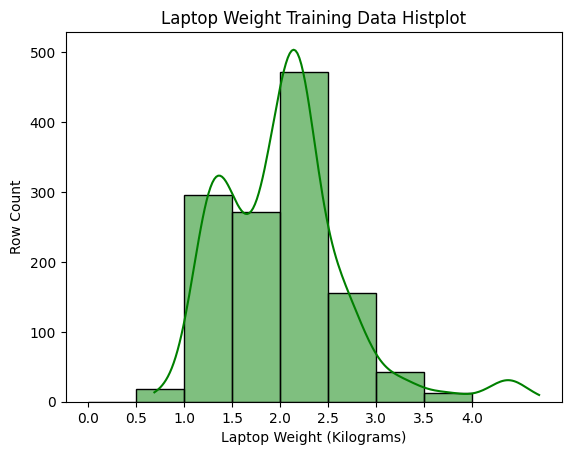

In [103]:
# Convert weight to numerical values by removing units "kg" and recasting as float
weight_kg = pd.DataFrame(price_df["Weight"].str.upper().str.split("KG").tolist(),columns = ["Weight","Blank"])["Weight"].astype("float")

# Create a histogram of weight values to ensure that there are no outliers or weird behavior
plot_bins = np.arange(
    start = int(weight_kg.min()), 
    stop = int(weight_kg.max())+0.5, 
    step = 0.5
)

ax = sns.histplot(data = weight_kg,kde=True,bins = plot_bins,color = "green")
ax.set_xticks(plot_bins)
ax.set_xlabel("Laptop Weight (Kilograms)")
ax.set_ylabel("Row Count")
ax.set_title("Laptop Weight Training Data Histplot");


### Section 3: Assemble and Evaluate Training Dataset

In [104]:
# Assemble all engineered features into a single dataframe
# this cell notes which features will need to be passed to LightGBM as integer-encoded type

X_prelim = pd.concat([
    manuf_encoded,      # encoded
    model_freq,         # numeric
    category_encoded,   # encoded
    screen_features,    # numerical
    cpu_features,       # encoded (brand, product); numeric (Ghz, core count)
    gpu_features,       # encoded (brand, product)
    ram_gb,             # numeric
    storage_features,   # numeric
    os_encoded,         # encoded
    version_encoded,    # encoded
    weight_kg           # numeric
],axis = 1
)

[Text(0.5, 1.0, 'Correlation Matrix of Model Numeric Features')]

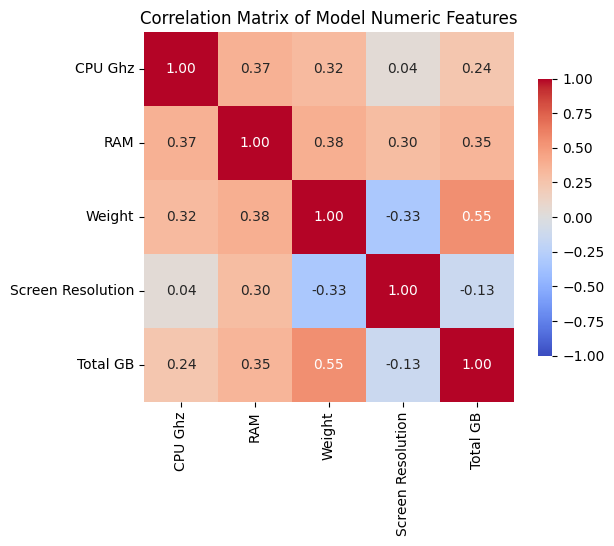

In [105]:
# Create a correlation matrix of numeric (not integer-encoded) values
sns.heatmap(
    data = X_prelim[[
        "CPU Ghz",
        "RAM",
        "Weight",
        "Screen Resolution",
        "Total GB"
        ]].corr(),
    vmin = -1,
    vmax = 1,
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    square = True,
    cbar_kws={"shrink":0.75}
).set(title = "Correlation Matrix of Model Numeric Features")


**Correlation Matrix Takeaways**
* There is surprisingly strong correlation between many of these features but no obvious opportunities to combine. 

* `Weight` should be held out of the dataset for now; it correlates strongly with CPU processing power and storage capacity, but does not generate value for users in the way that CPU and storage do. 

In [106]:
X_prelim = X_prelim.drop("Weight",axis = 1)

During model evaluation, I built a frequency feature (i.e. count of instances appearing in the dataset) for Model. In early model training runs, it had the highest feature importance.

I removed this feature because, when serving predictions through the model API, this feature will have no meaning. All models passed through prediction requests will have an n = 1.

In [107]:
X_prelim = X_prelim.drop("Model Freq",axis = 1)

### Section 4: Model Fitting and Hyperparameter Tuning

In [108]:
# make sure that all datatypes are numeric before proceeding to fitting & tuning
X_typelist = X_prelim.select_dtypes(exclude=["number"]).columns.tolist()

try:
    X_typelist == []
except:
    TypeError("All values in the training dataset must be numeric datatypes")

print(X_typelist)

[]


In [109]:
# convert column names to snake case (ensures compatibility with LightGBM)
X_prelim.columns = X_prelim.columns.to_frame()[0].str.replace(" ","_").str.lower()

In [110]:
# separate input variables and target variable
X = X_prelim.copy()
y = price_df["Price"]

In [111]:
# explicity identify data columns containing encoded variables
# LightGBM needs to be told that these columns are encoded and not ordinary numeric data
categorical_cols = [
    "manufacturer",
    "category",
    "cpu_brand",
    "cpu_product",
    "gpu_brand",
    "gpu_product",
    "operating_system",
    "operating_system_version"
]

# LightGBM docs recommend that all encoded columns be explicity set to integer type
for col in categorical_cols:
    X[col] = X[col].astype("int")

In [112]:
# tune hyperparameters using optuna
# objective is maximum cross-validated r2 score

def objective(trial):

    params = {
        "num_threads":4, 
        "objective":"regression",
        "metric":"mean_squared_error",
        "verbosity":-1,
        "boosting_type":"gbdt",
        "reg_alpha":trial.suggest_float("reg_alpha",1e-8,1.0,log=True),
        "reg_lambda":trial.suggest_float("reg_lambda",1e-8,1.0,log=True),
        "num_leaves":trial.suggest_int("num_leaves",5,30),
        "max_depth":trial.suggest_int("max_depth",5,15),
        "learning_rate":trial.suggest_float("learning_rate",0.01,0.2),
        "n_estimators":trial.suggest_int("n_estimators",100,1000),
        "min_child_samples":trial.suggest_int("min_child_samples",5,50),
        "subsample":trial.suggest_float("subsample",0.6,1.0),
        "colsample_bytree":trial.suggest_float("colsample_bytree",0.6,1.0)
    }
    
    cv = KFold(n_splits=5,shuffle = True,random_state = 42)
    scores = []

    for train_index,valid_index in cv.split(X):
        X_train,X_valid = X.iloc[train_index],X.iloc[valid_index]
        y_train,y_valid = y.iloc[train_index],y.iloc[valid_index]

        # log-transform the target variable to manage issues with right skew
        y_train_log = np.log1p(y_train)
        y_valid_log = np.log1p(y_valid)

        train_data_optuna = lgb.Dataset(X_train,y_train_log,categorical_feature=categorical_cols)
        valid_data_optuna = lgb.Dataset(X_valid,y_valid_log,categorical_feature=categorical_cols,reference = train_data_optuna)

        model_optuna = lgb.train(
            params = params,
            train_set = train_data_optuna,
            valid_sets = [valid_data_optuna],
            num_boost_round = 1000,
            callbacks = [lgb.early_stopping(stopping_rounds = 50)],
        )

        y_pred_log = model_optuna.predict(X_valid,num_iteration = model_optuna.best_iteration)
        y_pred = np.expm1(y_pred_log)
        fold_r2 = r2_score(y_valid,y_pred)
        scores.append(fold_r2)

    return np.mean(scores)


In [113]:
# # execute the hyperparameter optimization and store the results on disk
# study = optuna.create_study(direction = "maximize")
# study.optimize(objective,n_trials = 100)
# joblib.dump(study,MODEL_PATH / "optuna_laptop_price_predictor_results.pkl")

In [114]:
study = joblib.load(MODEL_PATH / "optuna_laptop_price_predictor_results.pkl")

In [115]:
print("Best Trial:")
trial = study.best_trial
print("     R2: {}".format(trial.value))
print("     Params: ")
for key, value in trial.params.items():
    print("     {}: {}".format(key,value))

Best Trial:
     R2: 0.8841956695147705
     Params: 
     reg_alpha: 2.7793732786774465e-08
     reg_lambda: 2.8930996491586605e-06
     num_leaves: 8
     max_depth: 13
     learning_rate: 0.14144297970920416
     n_estimators: 916
     min_child_samples: 5
     subsample: 0.6942383174306365
     colsample_bytree: 0.6924894608587872


In [116]:
# # train the final model using the results of the hyperparameter optimization
# train_data = lgb.Dataset(data = X, label = np.log1p(y),categorical_feature=categorical_cols)
# model = lgb.train(params = study.best_trial.params,train_set=train_data,num_boost_round=1000)
# joblib.dump(model,MODEL_PATH / "laptop_price_model.pkl")


In [117]:
model = joblib.load(MODEL_PATH / "laptop_price_model.pkl")

### Section 5: Model Results

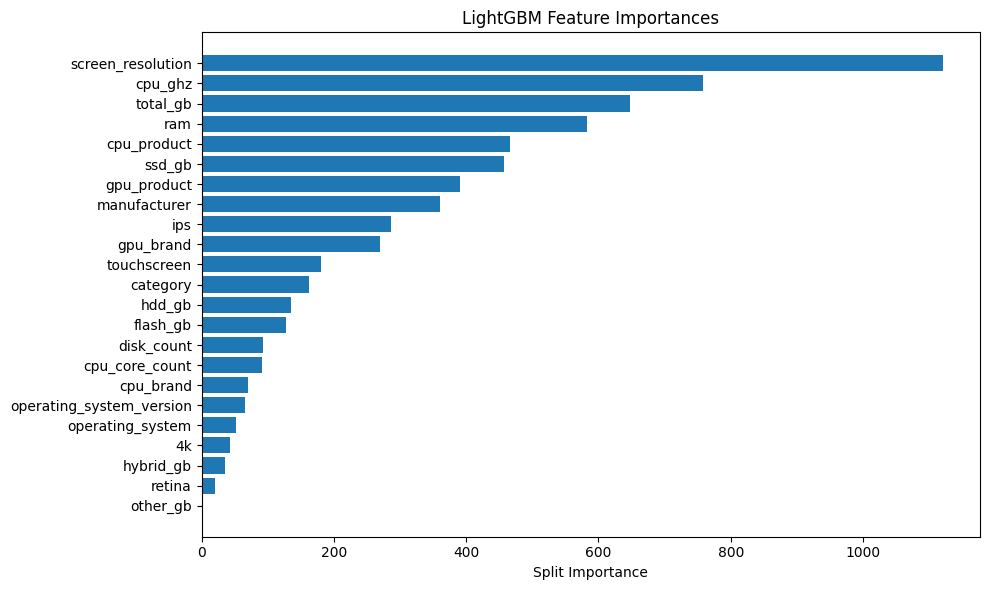

In [118]:
# check model feature importances

importances = model.feature_importance()
feature_names = model.feature_name()

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.gca().invert_yaxis()  
plt.title("LightGBM Feature Importances")
plt.xlabel("Split Importance")
plt.tight_layout()
plt.show()


**Feature Importance Takeaways**
* Top features are drivers of value in the real world (screen sharpness, processing speed, storage, memory)
* No obvious overfitting to the training set

### Section 6: API Preparation

Store feature list and encoding maps for use in the API

In [119]:
feature_encoding_maps = {
    "manufs":manuf_code_map,
    # "models":model_code_map # did not create or use this variable
    "category":category_code_map,
    "cpu_brand":cpu_brand_code_map,
    "cpu_prod":cpu_prod_code_map,
    "gpu_brand":gpu_brand_code_map,
    "gpu_prod":gpu_prod_code_map,
    "os":os_code_map,
    "os_version":version_code_map
}

# joblib.dump(feature_encoding_maps,MODEL_PATH / "laptop_feature_encoding_maps.pkl")

In [120]:
# store model feature names as a separate file on disk; this list will be used in the prediction API
model_features = X.columns.tolist()
# joblib.dump(model_features,MODEL_PATH / "laptop_price_model_features.pkl")

In [121]:
replace_strings = {
    "manufs":replace_string_manuf,
    # "models": replace_string_model, # did not use this variable
    "category":replace_string_cat,
    "cpu_brand":replace_string_cpu_brand,
    "cpu_prod":replace_string_cpu_prod,
    "gpu_brand":replace_string_gpu_brand,
    "gpu_prod":replace_string_gpu_prod,
    "os":replace_string_os,
    "os_version":replace_string_version
}

# joblib.dump(replace_strings, MODEL_PATH / "laptop_feature_replace_strings.pkl")